In this notebook, I try aligning a translation of Doronin's books. 

This turns out to be fucking difficult; the first book is translated very inexactly; in the second one, about 1000 sentences in a row are just missing in the translation.

In [1]:
import docx2txt

In [2]:
import razdel
import re
import pandas as pd
import numpy as np

In [3]:
def sentenize(text, big_splitter='\n{3,}', min_len=3):
    sents = []
    for part in re.split(big_splitter, text):
        for sent in razdel.sentenize(part):
            if len(sent.text) >= min_len:
                sents.append(sent.text)
    return sents

In [28]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import random
import json
import razdel
import re
import matplotlib.pyplot as plt
import xxhash

In [29]:
import torch
from transformers import AutoTokenizer, AutoModel

In [30]:
model_name = "slone/LaBSE-en-ru-myv-v2"

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).cuda();

c:\users\david\appdata\local\programs\python\python39\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [32]:
import slone_nmt.document_alignment
from importlib import reload
reload(slone_nmt.document_alignment)

from slone_nmt.document_alignment import align3, embed, get_penalized_sims, align_docs

In [107]:
from slone_nmt import myv_translit

# Aligning Kuzma

In [4]:
%%time
kuzma_rus = docx2txt.process('../../data-2023/raw/2books/А. Доронин. Кузьма Алексеев/Рус. Кузьма Алексеев.docx')

Wall time: 677 ms


In [5]:
%%time
kuzma_myv = docx2txt.process('../../data-2023/raw/2books/А. Доронин. Кузьма Алексеев/Эрз. Кузьма Алексеев.docx')

Wall time: 623 ms


In [6]:
print(type(kuzma_rus))
print(len(kuzma_rus))
print(len(kuzma_myv))

<class 'str'>
678644
823168


In [7]:
print(len(kuzma_rus.split('\n\n')))
print(len(kuzma_myv.split('\n\n')))

3684
5610


In [8]:
sents_rus = sentenize(kuzma_rus)
sents_myv = sentenize(kuzma_myv)

In [9]:
print(len(sents_rus))
print(len(sents_myv))

10975
12839


In [10]:
kuzma_myv.count('388') # I manually found that it is the end of the main text

1

In [11]:
full_clean_rus = kuzma_rus[:]
full_clean_myv = kuzma_myv.split('388')[0]

In [12]:
print(len(full_clean_rus))
print(len(full_clean_rus))

678644
678644


In [13]:
full_clean_myv = re.sub('\n\n\d{1,3}\n\n', '', full_clean_myv)

In [14]:
sents_rus = sentenize(full_clean_rus)
sents_myv = sentenize(full_clean_myv)

print(len(sents_rus))
print(len(sents_myv))

10975
12495


In [15]:
print(len(full_clean_rus.split('\n\n')))
print(len(full_clean_myv.split('\n\n')))

3684
4642


In [16]:
print(kuzma_rus.count('*'))
print(kuzma_myv.count('*'))

432
431


In [17]:
rus2 = re.sub('\*\s*\*\s*\*', '***', kuzma_rus)
myv2 = re.sub('\*\s*\*\s*\*', '***', kuzma_myv)

In [18]:
print(rus2.count('***'))
print(myv2.count('***'))

144
143


In [19]:
parts1_rus = rus2.split("***")
parts1_myv = myv2.split("***") + ['']

In [20]:
parts_df = pd.DataFrame(dict(
    len_rus = [len(x) for x in parts1_rus],
    len_myv = [len(x) for x in parts1_myv],
))
parts_df['len_ratio'] = np.minimum(parts_df.len_rus, parts_df.len_myv) / np.maximum(parts_df.len_rus, parts_df.len_myv)

In [21]:
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 200

In [22]:
parts_df

,len_rus,len_myv,len_ratio
0,11121,4178,0.375686
1,7158,6674,0.932383
2,4601,7611,0.604520
3,8106,3823,0.471626
4,4451,5866,0.758779
5,10624,6092,0.573419
6,7883,13443,0.586402
7,4646,7892,0.588697
8,4514,5277,0.855410
9,3894,4495,0.866296


In [23]:
tmp = '''И Николка, глядя на огонь, принялся мечтать о своих подвигах.

* * *

Шагая не спеша домой'''

Both the number of paragraphs and the number of characters is pretty different

In [24]:
print(kuzma_rus[:20000])

Александр Доронин

Кузьма Алексеев

























Саранск

Издательский дом «Книга»

2014



ТАМ, В ЛЕСАХ ГУСТЫХ...

С горы Отяжка, сплошь покрытой непроходимым лесом, донесся трубный лосиный зов. Лесной царь словно призывал кого-то разделить свое одиночество, а, может быть, заявлял о своих правах на эту гору, лес, весь окружающий его мир.

Жители Сеськина в эту зиму видели лося часто и дивились его огромному росту. Крупную голову лесного красавца венчали лопатообразные рога: каждый о шести ветках, выросших из единого широкого корня. На лбу его — белая приметная звездочка. Спина, крепкая и мощная, лоснилась на солнце. Люди между собой называли лося Отяжкой — по имени горы, на которой он появился. И после каждой нечаянной встречи с ним рассказывали друг другу обо всех мельчайших подробностях. Лось сторонился человека, к селу близко не подходил, но и гору не покидал. А гора Отяжка была для сеськинцев их хранительницей и кормилицей. С северной стороны она защищала село от прониз

In [25]:
print(kuzma_myv[:20000])

Се ломанесь уцяскав, конась 

эсь раськедензэ мелявты.



Эрзянь валмеревкс

Александр Доронин чачсь 1947 иестэ Покш Игнадвеле ёнксонь Петровка велинесэ.

Прядсь Ицялонь педучилища ды А.М. Горькоень лемсэ Литературной институт.

«Кочкодыкесь — пакся нармунь», «Баягань сулейть» романонь, «Кинть ютасы молицясь» художественной очеркень ды стихень ниле сборникень автор.

Мордовия Республикань заслуженной писатель, Государственной премиянь ды Мордовиянь комсомолонь лауреат.

Эри Саранск ошсо..





Александр Доронин



КУЗЬМА

АЛЕКСЕЕВ

Роман





















Саранск

Мордовской книжной издательствась

2001











УДК 821.511.152

ББК 84 (2Рос-Морд)

Д 69







Рецензентэсь: Николай Ишуткин

Художникесь: Виктор Федюнин









































ISBN 5 - 7595 - 1499 -7

© Доронин Александр Макарович, 2001

TOCO, ТУСТО ВИРТНЕСЭ



Отяжке пандонть прясто, кона сэрьс вельтязь сэрей чувтсо, паразевсь сярдо. Парамозо мукстницяль, теке идем ракшась тердсь кинь-бути. Те сярд

In [26]:
print(full_clean_myv[-20000:])

нть кутмори, лангстонзо солыть ловшушмотне, кодат сэрейть сынь авольть уле.

Эрьва цецянть эсензэ мазызэ, Кузьма. Чинезэяк эсензэ. Эрьва ярсамканть эсензэ танстезэ ды ялатеке лемезэ вейке — пекень пештямка.

Пильгс тон, Кузьма, а сюконякшнат? Видестэ теят! Алов прамось леметь а кепедьсы. Кие пильгть палеи, сенень а кемить.

Се инязоронть часиязо, Кузьма, арась, коната кедень нолсицят вечки. Сень вечкть, кие асатыкстэть чамас корты, аволь сельме удалга. Кедень палсемась — превтементень ярсамка. Зяро превей ломанть тень эйстэ ёмасть!

Манчицянть кельбрясо, Кузьма, — медь, седейсэнзэ — яд. Медьс карвотне седеяк пек вайсекшнить.

Лейтне, Кузьма, таргить иневедьс, кшнись — магнитэнтень, тикшетне — чинтень, нармунтне — лембе мастеров, ломантне — валдо уцяскас.

...Арсесь Кузьма Алексеев ды эзь фатяяк, кода менелесь лазовсь валскень зорясо, пертьпельксэнть сэрьс ожосо пургсизе.

Ды вана архиереесь таго терди. Кодамо, каня, кортамо мартонзо ушоды? — Валост чамдозельть, од сон тензэ мезеяк а ёв

In [27]:
print(full_clean_rus[-20000:])

, — должен записать: «Отказывается отвечать на вопросы»?

— Извольте, раз требуете, скажу, — вдруг заявил Алексеев. — Я хотел одного: вместе с моими односельчанами продолжать традиции моего народа. А народ мой много веков поклонялся только своим богам. Теперь мы крещены, но счастье отвернулось от нас. Живем в кабале и нищете. Наше спасение в прежней вере. Дух Мельседея Верепаза явился ко мне и сказал, что Христос сложил свой чин и передал его другому. И этот спаситель придет с Запада... А мы пока должны держаться своих древних обычаев и готовиться к страшному суду...

— Ну хватит! Я довольно наслушался. — Ребиндер направился к двери. — Прочистите ему мозги. Может, забудет свой бред. — И кивнул одобрительно Донату.

Канцелярист, подхватив бумаги, юркнул вслед за Ребиндером.

Как только за ними закрылась дверь, Донат подошел к Кузьме: — Язычник, теперь пришла пора испытать мое изобретение. Иди-ка сюда, — и толкнул Алексеева к станку. Подскочившие стражники подхватили его за руки и стали 

In [33]:
batch_size = 12500

In [34]:
prev_start_src = 0
prev_start_tgt = 0

In [35]:
src_sents = sents_rus[prev_start_src:prev_start_src+batch_size]
tgt_sents = sents_myv[prev_start_tgt:prev_start_tgt+batch_size]

In [36]:
src_embs = embed(src_sents, model, tokenizer, progress=True)
tgt_embs = embed(tgt_sents, model, tokenizer, progress=True)

  0%|          | 0/686 [00:00<?, ?it/s]

  0%|          | 0/781 [00:00<?, ?it/s]

Aligning 10k\*10k document pair takes half my RAM. 

For longer documents, I'll have to do something else, like nearest neighbour search, maybe. 

(10975, 12495)
8259
Wall time: 7min 15s


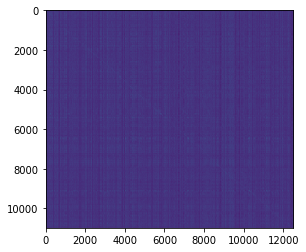

In [37]:
%%time
sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.1, abs_penalty=0.1)

print(sims_rel.shape)
pair_ids = align3(sims_rel)
print(len(pair_ids))
plt.imshow(sims_rel);

In [38]:
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 500

In [39]:
%%time

doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
# doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
# doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()

print('mean aligned penalized sim:', doc_df.sim_pnlz.mean())
print('mean gross raw sim:        ', doc_df.sim.fillna(0).mean())


doc_df

mean aligned penalized sim: 0.3370542954254226
mean gross raw sim:         0.2942658499205411
Wall time: 111 ms


,tgt_sent_id,tgt_sent,src_sent_id,src_sent,sim,sim_pnlz,docs_sim
0,0.0,"Се ломанесь уцяскав, конась \n\nэсь раськедензэ мелявты.",NaN,NaN,NaN,NaN,0.294266
1,1.0,Эрзянь валмеревкс\n\nАлександр Доронин чачсь 1947 иестэ Покш Игнадвеле ёнксонь Петровка велинесэ.,NaN,NaN,NaN,NaN,0.294266
2,2.0,Прядсь Ицялонь педучилища ды А.М. Горькоень лемсэ Литературной институт.,NaN,NaN,NaN,NaN,0.294266
3,3.0,"«Кочкодыкесь — пакся нармунь», «Баягань сулейть» романонь, «Кинть ютасы молицясь» художественной очеркень ды стихень ниле сборникень автор.",NaN,NaN,NaN,NaN,0.294266
4,4.0,"Мордовия Республикань заслуженной писатель, Государственной премиянь ды Мордовиянь комсомолонь лауреат.",NaN,NaN,NaN,NaN,0.294266
...,...,...,...,...,...,...,...
15206,12490.0,"Ломантне — нармунть, конат эсь мельтнесэ менельга ливтнить, сынсь яксить мода ланга.",NaN,NaN,NaN,NaN,0.294266
15207,12491.0,Ды эрьва эскельксэст путомсто маней бажамотнес капшакшныть.,NaN,NaN,NaN,NaN,0.294266
15208,12492.0,"Эрьва валскенть сынь кенярдозь ушолить, эрьва чокшнестэнть маднить вандынь чинтень виень пурнамо.",NaN,NaN,NaN,NaN,0.294266
15209,12493.0,"Од валскесь — ютазенть поладкс, ды сон истямокс карми улеме, кодамокс эйсэнзэ минсь тейтяно.",NaN,NaN,NaN,NaN,0.294266


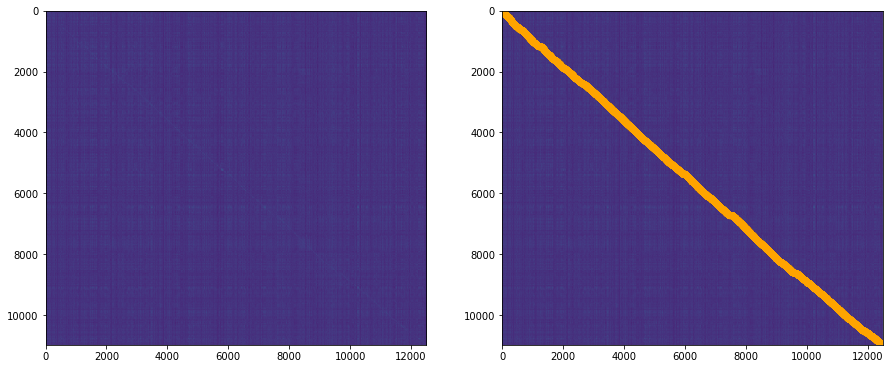

In [40]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(sims_rel);
plt.subplot(1, 2, 2)
plt.imshow(sims_rel);
plt.scatter(
    doc_df.dropna().tgt_sent_id.astype(int),
    doc_df.dropna().src_sent_id.astype(int),
    edgecolor='orange',
    facecolor='none',
);

In [41]:
doc_df.describe()

,tgt_sent_id,src_sent_id,sim,sim_pnlz,docs_sim
count,12495.000000,10975.000000,8259.000000,8259.000000,1.521100e+04
mean,6247.000000,5487.000000,0.541964,0.337054,2.942658e-01
std,3607.140141,3168.353936,0.186339,0.180479,5.551298e-17
min,0.000000,0.000000,0.188375,0.000449,2.942658e-01
25%,3123.500000,2743.500000,0.385442,0.185166,2.942658e-01
50%,6247.000000,5487.000000,0.544790,0.341600,2.942658e-01
75%,9370.500000,8230.500000,0.692959,0.483183,2.942658e-01
max,12494.000000,10974.000000,1.000000,0.790026,2.942658e-01


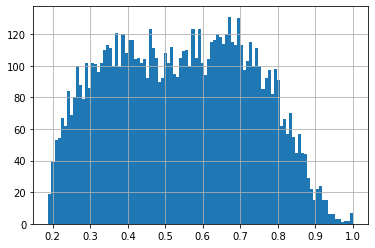

In [43]:
doc_df.sim.hist(bins=100);

In [42]:
doc_df.to_csv('../../data-2023/aligned/kuzma_alinged_20231104.tsv', sep='\t', index=None)

# перепелка

In [197]:
koch_rus = docx2txt.process('../../data-2023/raw/2books/А. Доронин. Перепелка... - роман на эрз. и рус. яз/Рус. Перепелка - птица полевая.docx')


koch_myv = docx2txt.process('../../data-2023/raw/2books/А. Доронин. Перепелка... - роман на эрз. и рус. яз/Эрз. Кочкодыкесь -пакся нармунь.docx')

In [198]:
print(len(koch_rus))
print(len(koch_myv))

560726
834925


In [199]:
sents_rus = sentenize(koch_rus)
sents_myv = sentenize(koch_myv)
print(len(sents_rus))
print(len(sents_myv))

10034
12018


In [271]:
batch_size = 300
batch_size = 12_500

In [272]:
src_offset, tgt_offset = 0, 0

In [273]:
src_sents = sents_rus[src_offset:src_offset+batch_size]
tgt_sents = sents_myv[tgt_offset:tgt_offset+batch_size]

In [274]:
src_embs = embed(src_sents, model, tokenizer, progress=True)
tgt_embs = embed(tgt_sents, model, tokenizer, progress=True)

  0%|          | 0/628 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

(10034, 12018)
9153


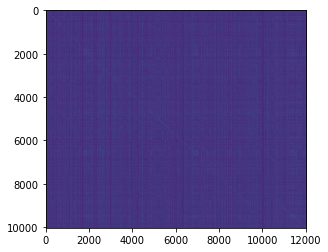

In [275]:
sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.1, abs_penalty=0.1)

print(sims_rel.shape)
pair_ids = align3(sims_rel)
print(len(pair_ids))
plt.imshow(sims_rel);

In [276]:
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 500

In [277]:
doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
# doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
# doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()

print('mean aligned penalized sim:', doc_df.sim_pnlz.mean())
print('mean gross raw sim:        ', doc_df.sim.fillna(0).mean())


doc_df

mean aligned penalized sim: 0.4287425733950852
mean gross raw sim:         0.4504897961002932


,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,docs_sim
0,0.0,Александр Доронин\n\nПерепёлка — птица полевая\n\nРОМАН,0.0,Александр Доронин\n\nКочкодыкесь — пакся нармунь\n\nРОМАН,0.926384,0.725773,0.45049
1,1.0,"Саранск\n\nИздательский дом «Книга»\n\n2012\n\n«Свет не только тот, который в окне,\n\n за окном его еще больше»\n\nЭрзянская поговорка\n\nПЕРВАЯ ГЛАВА",1.0,"Саранск\n\nМордовской книжной издательствась\n\n1993\n\n Валдось аволь ансяк се, конась вальмасо,\n\n вальманть томбале сондензэ седеяк ламо.\n\n ...",0.323842,0.166013,0.45049
2,NaN,NaN,2.0,ВАСЕНЦЕ ПЕЛЬКС,NaN,NaN,0.45049
3,2.0,"Низко плывущие густые облака, кажется, еще более утяжелили мартовскую ночь.",3.0,Алга уиця тусто пельтне мартонь чокшненть седеяк стакалгавтызь.,0.652842,0.435183,0.45049
4,3.0,В селе Вармазейка всё погрузилось во тьму.,NaN,NaN,NaN,NaN,0.45049
...,...,...,...,...,...,...,...
12894,10031.0,"А где хлеб, там и песни!",NaN,NaN,NaN,NaN,0.45049
12895,10032.0,Кочкодыкесь — паксянь нармунь!,NaN,NaN,NaN,NaN,0.45049
12896,10033.0,293\n\n325,NaN,NaN,NaN,NaN,0.45049
12897,NaN,NaN,12016.0,"Сайсынзе ды путсынзе ломантнень икелев: вана, ванодо, неть тевтнень тынсь ушодынк!..",NaN,NaN,0.45049


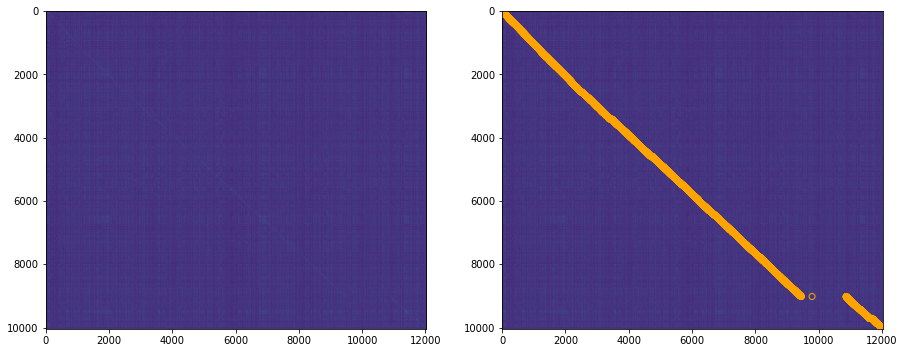

In [278]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(sims_rel);
plt.subplot(1, 2, 2)
plt.imshow(sims_rel);
plt.scatter(
    doc_df.dropna().tgt_sent_id.astype(int),
    doc_df.dropna().src_sent_id.astype(int),
    edgecolor='orange',
    facecolor='none',
);

In [279]:
doc_df.describe()

,src_sent_id,tgt_sent_id,sim,sim_pnlz,docs_sim
count,10034.000000,12018.000000,9153.000000,9153.000000,1.289900e+04
mean,5016.500000,6008.500000,0.634859,0.428743,4.504898e-01
std,2896.710634,3469.442102,0.171890,0.165996,1.110266e-16
min,0.000000,0.000000,0.183543,0.001586,4.504898e-01
25%,2508.250000,3004.250000,0.518325,0.316439,4.504898e-01
50%,5016.500000,6008.500000,0.661397,0.455212,4.504898e-01
75%,7524.750000,9012.750000,0.769490,0.558374,4.504898e-01
max,10033.000000,12017.000000,1.000000,0.774094,4.504898e-01


In [281]:
doc_df.to_csv('../../data-2023/aligned/perepelka_alinged_20231104.tsv', sep='\t', index=None)

#### Below, there is an attempt to align Perepelka with a moving window. It broke in the end, because of a discontinuity.

I am moving through the document with a sliding window, and matching whatever I find within.

This looks fast!

In [239]:
batch_size = 300
overlap_factor = 0.5

In [244]:
src_offset = 0
tgt_offset = 0
src_offsets = []
tgt_offsets = []
result_dfs = []

In [245]:
for i in trange(int(len(sents_myv) * 2 / batch_size / overlap_factor)):
    if src_offset > len(sents_rus) or tgt_offset > len(sents_myv):
        break
    src_sents = sents_rus[src_offset:src_offset+batch_size]
    tgt_sents = sents_myv[tgt_offset:tgt_offset+batch_size]
    src_embs = embed(src_sents, model, tokenizer)
    tgt_embs = embed(tgt_sents, model, tokenizer)
    sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.1, abs_penalty=0.1)
    pair_ids = align3(sims_rel)
    
    doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
    src_offsets.append(src_offset)
    tgt_offsets.append(tgt_offset)
    result_dfs.append(doc_df)
    
    tmp = doc_df.dropna()
    row = tmp.iloc[int(tmp.shape[0] * overlap_factor)]
    src_offset += int(row.src_sent_id)
    tgt_offset += int(row.tgt_sent_id)
    print(i, src_offset, tgt_offset, doc_df.sim.isnull().mean(), doc_df.sim.mean())

  0%|          | 0/160 [00:00<?, ?it/s]

0 153 148 0.1927710843373494 0.6654154585395322
1 302 291 0.17073170731707318 0.6464700256077497
2 451 444 0.1927710843373494 0.6238687749077425
3 599 589 0.21428571428571427 0.6063896789364761
4 752 733 0.1981981981981982 0.6074564098383214
5 898 872 0.1981981981981982 0.6140413468526292
6 1052 1019 0.18731117824773413 0.616180277931328
7 1193 1161 0.23529411764705882 0.5997238879602999
8 1353 1305 0.23008849557522124 0.607191970947436
9 1495 1454 0.20359281437125748 0.625663735019184
10 1646 1603 0.208955223880597 0.6034388287227225
11 1794 1757 0.17073170731707318 0.5995845809887959
12 1943 1903 0.1651376146788991 0.6020676857373926
13 2084 2044 0.2404692082111437 0.5999626153235883
14 2238 2189 0.27089337175792505 0.5986802183819818
15 2390 2332 0.208955223880597 0.5856637176536379
16 2529 2472 0.2905982905982906 0.5785598016227443
17 2658 2625 0.34710743801652894 0.5941883748229316
18 2795 2780 0.27586206896551724 0.5995758165962722
19 2945 2934 0.1762917933130699 0.60931653430221

157 10032 11148 0.9966777408637874 0.5033352454503377
158 10032 11148 0.9966777408637874 0.5033352454503377
159 10032 11148 0.9966777408637874 0.5033352454503377


In [246]:
src_offset, len(sents_rus), tgt_offset, len(sents_myv)

(10032, 10034, 11148, 12018)

In [249]:
result_dfs[62]

,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz
0,0.0,Рузавин лбом пропахал прогретый за день песок и во весь рост растянулся.,0.0,"Рузавин эзь чарькодеяк, кона шкане кедензэ пиксэкс пувордазельть удалов.",0.391313,0.217452
1,1.0,— Хва-а-тит! — прохрипел он.,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,"Васня терявтнесь лисеме Числавонь алдо ды, ансяк зярдо келей конясонзо сокардызе чинь псисэнть калязь песоконть, венемсь ды кижнэзь ёртсь:\n\n— Са-ты!..",NaN,NaN
3,2.0,"— Хватит, так хватит.",2.0,— Саты дык саты.,0.620630,0.436920
4,3.0,"Я сначала думал, что землю будешь целовать, — сквозь зубы выпалил Судосев и засмеялся, когда \n\n256\n\nувидел убегающего Олега.",3.0,"Мон васня арсинь, моданть арсят паламонзо, — пееньбачк мерсь Судосев ды пейдезевсь, зярдо неизе пире пева оргодиця Олегень.",0.888596,0.694739
5,4.0,"У того ноги длинные, да сам слабак.",4.0,"Сень пильгензэ кувакат, ды сонсь уш пек лажныця.",0.611384,0.427288
6,5.0,Л еще за друга хотел заступиться!,5.0,А оштё ялганзо кис сась аштеме!,0.724131,0.536586
7,6.0,* * *\n\nВ чужих руках крошка хлеба кажется ломтем.,6.0,***\n\nЛомань кедьсэ кши паморьксэськак неяви печтекс.,0.755219,0.573094
8,7.0,Кое-кто думает: все с неба падает даром.,7.0,"Кой-кить арсить, весемесь пракшны менельстэ, рунгонь апак ливеськавтне.",0.504378,0.333117
9,8.0,Не работая.,NaN,NaN,NaN,NaN


# Aligning Physics

In [64]:
with open('../../data-2023/raw/Физика/physics_myv.txt', 'r') as f:
    sents_myv = sentenize(f.read(), big_splitter='\n')
with open('../../data-2023/raw/Физика/physics_rus.txt', 'r') as f:
    sents_rus = sentenize(f.read(), big_splitter='\n')

In [66]:
print(len(sents_myv))
print(len(sents_rus))

2062
1365


In [67]:
batch_size = 300
batch_size = 12_500

In [68]:
src_offset, tgt_offset = 0, 0

In [69]:
src_sents = sents_rus[src_offset:src_offset+batch_size]
tgt_sents = sents_myv[tgt_offset:tgt_offset+batch_size]

In [70]:
src_embs = embed(src_sents, model, tokenizer, progress=True)
tgt_embs = embed(tgt_sents, model, tokenizer, progress=True)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

(1365, 2062)
1300


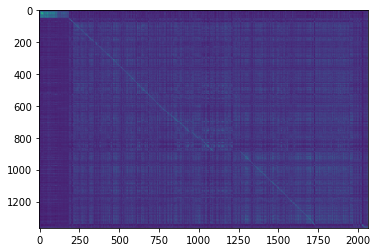

In [71]:
sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.1, abs_penalty=0.1)

print(sims_rel.shape)
pair_ids = align3(sims_rel)
print(len(pair_ids))
plt.imshow(sims_rel);

In [72]:
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 500

In [73]:
doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
# doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
# doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()

print('mean aligned penalized sim:', doc_df.sim_pnlz.mean())
print('mean gross raw sim:        ', doc_df.sim.fillna(0).mean())


doc_df

mean aligned penalized sim: 0.5087615995572613
mean gross raw sim:         0.439524242200667


,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,docs_sim
0,0.0,Валдаж Андю (Arpad Valdazs),0.0,Валдаж Андю (Arpad Valdazs),1.000000,0.822694,0.439524
1,1.0,МЕХАНИКА,1.0,МЕХАНИКА,1.000000,0.760928,0.439524
2,NaN,NaN,2.0,ЭРЗЯНЬ КЕЛЬСЭ,NaN,NaN,0.439524
3,2.0,С ПРИМЕРАМИ И ЗАДАЧАМИ,3.0,АРАВТОВКС ДЫ НЕВТЕМА МАРТО,0.604935,0.408414,0.439524
4,3.0,ПЕРЕВОД С ЭРЗЯНСКОГО,NaN,NaN,NaN,NaN,0.439524
...,...,...,...,...,...,...,...
2122,NaN,NaN,2057.0,"Москов, Педагогикань ды тонавтома книгань государствань издательствась 1934 г.",NaN,NaN,0.439524
2123,NaN,NaN,2058.0,"10. Тепловая электрическая станция – это очень просто: учеб. пособие / К.Э. Аронсон, Ю.М. Бродов, Н.В.Желонкин, М.А. Ниренштейн: под общ. ред. д-ра техн. наук проф. Ю.М. Бродова.",NaN,NaN,0.439524
2124,NaN,NaN,2059.0,"– Екатеринбург: изд-во Урал. ун-та, 2016, 203, [1] c.",NaN,NaN,0.439524
2125,NaN,NaN,2060.0,11. Кириллов В.А. Сычев В.В. Шейндлин А.Е. Техническая термодинамика.,NaN,NaN,0.439524


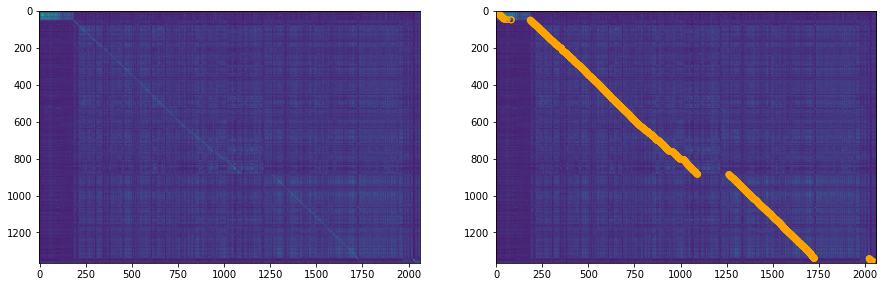

In [74]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(sims_rel);
plt.subplot(1, 2, 2)
plt.imshow(sims_rel);
plt.scatter(
    doc_df.dropna().tgt_sent_id.astype(int),
    doc_df.dropna().src_sent_id.astype(int),
    edgecolor='orange',
    facecolor='none',
);

In [75]:
doc_df.describe()

,src_sent_id,tgt_sent_id,sim,sim_pnlz,docs_sim
count,1365.00000,2062.000000,1300.000000,1300.000000,2.127000e+03
mean,682.00000,1030.500000,0.719129,0.508762,4.395242e-01
std,394.18587,595.392448,0.160810,0.152522,5.552421e-17
min,0.00000,0.000000,0.190103,0.008347,4.395242e-01
25%,341.00000,515.250000,0.625226,0.423030,4.395242e-01
50%,682.00000,1030.500000,0.738313,0.529444,4.395242e-01
75%,1023.00000,1545.750000,0.826878,0.609364,4.395242e-01
max,1364.00000,2061.000000,1.000000,0.827808,4.395242e-01


In [76]:
doc_df.to_csv('../../data-2023/aligned/physics_alinged_20231104.tsv', sep='\t', index=None)

# Aligning the prince

In [84]:
with open('../../data-2023/raw/Маленький принц/prince_myv_fra.txt', 'r') as f:
    sents_myv_fra = sentenize(f.read(), big_splitter='\n\n')
with open('../../data-2023/raw/Маленький принц/prince_rus_fra.txt', 'r') as f:
    sents_rus_fra = sentenize(f.read(), big_splitter='\n\n')

In [85]:
print(len(sents_myv_fra))
print(len(sents_rus_fra))

2978
2953


In [110]:
sents_myv = [sent for sent in sents_myv_fra if myv_translit.detect_script(sent) == 'cyr']
sents_rus = [sent for sent in sents_rus_fra if myv_translit.detect_script(sent) == 'cyr']
print(len(sents_myv))
print(len(sents_rus))

1501
1492


In [112]:
src_sents = sents_rus
tgt_sents = sents_myv

In [113]:
src_embs = embed(src_sents, model, tokenizer, progress=True)
tgt_embs = embed(tgt_sents, model, tokenizer, progress=True)

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

(1492, 1501)
1463


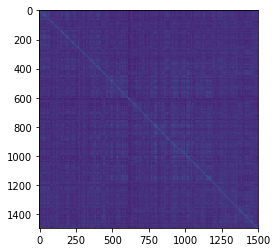

In [114]:
sims, sims_rel = get_penalized_sims(src_sents, tgt_sents, src_embs, tgt_embs, rel_penalty=0.1, abs_penalty=0.1)

print(sims_rel.shape)
pair_ids = align3(sims_rel)
print(len(pair_ids))
plt.imshow(sims_rel);

In [115]:
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 500

In [116]:
doc_df = align_docs(src_sents, tgt_sents, pair_ids, sims, sims_rel)
# doc_df['src_doc_hash'] = xxhash.xxh3_64_hexdigest(item['article_erz']['link'])
# doc_df['tgt_doc_hash'] = xxhash.xxh3_64_hexdigest(cand['link'])
doc_df['docs_sim'] = doc_df.sim.fillna(0).mean()

print('mean aligned penalized sim:', doc_df.sim_pnlz.mean())
print('mean gross raw sim:        ', doc_df.sim.fillna(0).mean())


doc_df

mean aligned penalized sim: 0.5074526216955583
mean gross raw sim:         0.6815615197286169


,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,docs_sim
0,0.0,"Эта книга издана ограниченным тиражом в количестве 300 экземпляров,\nиз которых 33 пронумерованы вручную.",0.0,"Те книгась нолдазь вишка тиражсо, ансяк 300 экземплярт, \n33 эйстэдест номеровазь кедьсэ",0.760552,0.577604,0.681562
1,1.0,"Как я понял, он решил странствовать с перелетными птицами.",1.0,"Вишка инязорнэ\nle petit prince\n \nКода мон чарькодинь, сон арси ливтнемс лембе масторов туиця нармунтнень марто.",0.401999,0.212754,0.681562
2,NaN,NaN,2.0,Авторонть артовксонзо марто,NaN,NaN,0.681562
3,NaN,NaN,3.0,Эрзякс ютавтызе\nАлександр Учеваткин,NaN,NaN,0.681562
4,2.0,"Леону Верту\nПрошу детей простить меня за то, что я посвятил эту книжку взрослому.",4.0,"Леон Вертнэнень\n \nКадык вишка эйкакштне а кежиявтыть лангозон сень кис, мекс те книганть алтыя покштнэнень.",0.612527,0.426907,0.681562
...,...,...,...,...,...,...,...
1525,1490.0,"Если вам случится тут\nпроезжать, заклинаю вас, не спешите, помедлите немного под этой звездой!",1496.0,"Бути зярдояк сави ардомс тия, мерян тенк, илядо капша, лоткаводо аламос те тештенть ало!",0.815228,0.620315,0.681562
1526,1491.0,"И если к вам подойдет маленький мальчик с золотыми волосами, если он\nбудет звонко смеяться и ничего не ответит на ваши вопросы, вы, уж конечно,\nдогадаетесь, кто он такой.",1497.0,"Зярдо ваксозонк сы сырнень черь марто вишка цёрыне, зярдо сон карми пек ракамо ды мезеяк а мери тынк кевкстеманк лангс, тынь, чарькодеви, содасынк, кие сон истямось.",0.833375,0.640367,0.681562
1527,NaN,NaN,1498.0,"Сестэ – пек энялдан! – илямизь стувто оймавтомс монь, седее куроксто сёрмадодо монень сонзэ самодо…",NaN,NaN,0.681562
1528,NaN,NaN,1499.0,Одт ды чуросто вастневиця валт,NaN,NaN,0.681562


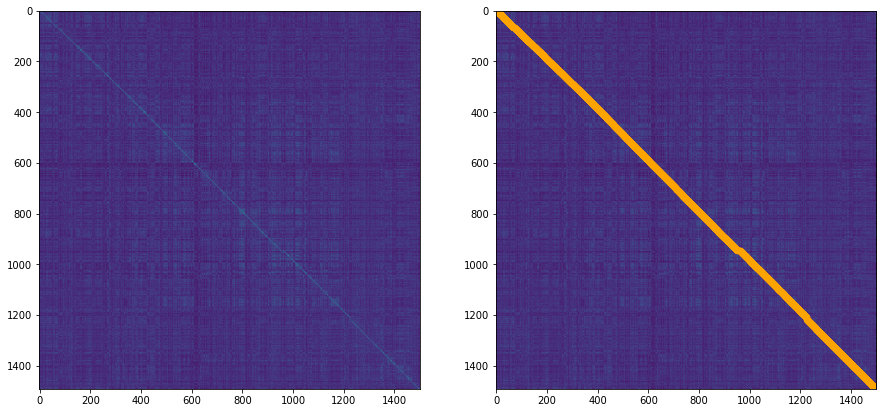

In [117]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(sims_rel);
plt.subplot(1, 2, 2)
plt.imshow(sims_rel);
plt.scatter(
    doc_df.dropna().tgt_sent_id.astype(int),
    doc_df.dropna().src_sent_id.astype(int),
    edgecolor='orange',
    facecolor='none',
);

In [119]:
i = 50
doc_df.iloc[i:i+30]

,src_sent_id,src_sent,tgt_sent_id,tgt_sent,sim,sim_pnlz,docs_sim
50,46.0,Воды\nу меня едва хватило бы на неделю.,49.0,Ведем лиядсь сехте ламо сисемшка чис.,0.405370,0.232192,0.681562
51,47.0,"Итак, в первый вечер я уснул на песке в пустыне, где на тысячи миль вокруг не было\nникакого жилья.",50.0,"Истя васенце чокшнестэнть мон матедевинь пустынянь човар лангс, тежа вайгельпеть эзть неявт кодаткак кудот.",0.749451,0.550023,0.681562
52,48.0,"Человек, потерпевший кораблекрушение и затерянный на плоту посреди\nокеана, — и тот был бы не так одинок.",51.0,"Венчсэ ваиця ломанесь, конась кадовсь Иневедь куншкас плот лангс, аволь истя ульнесь ськамонзо, кода маринь прясон мон.",0.627804,0.444167,0.681562
53,49.0,"Вообразите же мое удивление, когда на рассвете меня\nразбудил чей-то тоненький голосок.",52.0,"Кода монь лиссть лангс сельмень, зярдо валске марто удомасто стявтымем кинь-бути чова вайгелезэ.",0.736914,0.538281,0.681562
54,50.0,Mais je me\n— Пожалуйста… нарисуй мне барашка!,NaN,NaN,NaN,NaN,0.681562
55,NaN,NaN,53.0,Сон мерсь:,NaN,NaN,0.681562
56,51.0,— А?,54.0,– Мезе?,0.472830,0.242017,0.681562
57,52.0,— Нарисуй мне барашка…,55.0,– Арт монень вишка ревине!,0.589404,0.382835,0.681562
58,53.0,"Я вскочил, точно надо мною грянул гром.",56.0,"Мон сеске сыргозинь, теке пургинесэ стявтымезь!",0.529681,0.346255,0.681562
59,54.0,Протер глаза.,NaN,NaN,NaN,NaN,0.681562


In [120]:
doc_df.describe()

,src_sent_id,tgt_sent_id,sim,sim_pnlz,docs_sim
count,1492.000000,1501.000000,1463.000000,1463.000000,1530.000000
mean,745.500000,750.000000,0.712775,0.507453,0.681562
std,430.847614,433.445691,0.135029,0.129193,0.000000
min,0.000000,0.000000,0.218996,0.007217,0.681562
25%,372.750000,375.000000,0.628402,0.430230,0.681562
50%,745.500000,750.000000,0.730859,0.527918,0.681562
75%,1118.250000,1125.000000,0.805229,0.596435,0.681562
max,1491.000000,1500.000000,1.000000,0.793417,0.681562


In [121]:
doc_df.to_csv('../../data-2023/aligned/prince_alinged_20231104.tsv', sep='\t', index=None)

# Join all the books

In [134]:
code2df = {}
for code in ['kuzma', 'perepelka', 'physics', 'prince']:
    code2df[code] = pd.read_csv(f'../../data-2023/aligned/{code}_alinged_20231104.tsv', sep='\t')
    code2df[code]['source_id'] = code

In [135]:
df_joint = pd.concat(list(code2df.values()))

In [138]:
df_joint.groupby('source_id').sim.describe()

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
kuzma,8259.0,0.541964,0.186339,0.188375,0.385442,0.544790,0.692959,1.0
perepelka,9153.0,0.634859,0.171890,0.183543,0.518325,0.661397,0.769490,1.0
physics,1300.0,0.719129,0.160810,0.190103,0.625226,0.738313,0.826878,1.0
prince,1463.0,0.712775,0.135029,0.218996,0.628402,0.730859,0.805229,1.0


In [137]:
df_joint.groupby('source_id').sample(3)

,tgt_sent_id,tgt_sent,src_sent_id,src_sent,sim,sim_pnlz,docs_sim,source_id
3062,2286.0,"Зосимень педявтызь стенантень, кедензэ тонгизь кшнинь кольцяс.",2088.0,"Зосима прислонили к стене, руки вставили в железные кольца.",0.906817,0.676920,0.294266,kuzma
6787,5422.0,"Тень кисэ эйсэнзэ вечксть аволь ансяк пелиласо тертязь ялгатне, урядниктнеяк.",4926.0,"За это его уважали не только закованные в кандалы каторжники, но и тюремщики.",0.832571,0.628810,0.294266,kuzma
2863,2114.0,"— Токшесь, автик кургот.",1949.0,"— Придет, открывай шире рот!",0.691587,0.469300,0.294266,kuzma
6241,5704.0,"Те, кода мерить, васенце ёвкс.",5496.0,"Это, как говорят, первая сказка.",0.899270,0.690837,0.450490,perepelka
10216,9402.0,"«Кода косто, весе велесь мери тензэ Нинка ды Нинка.",8975.0,"— «Как откуда, все село ей говорит: Нинка да Нинка.",0.913547,0.709276,0.450490,perepelka
1675,1489.0,"Ванса, Инешкесь паро ладсо мартом, оякс-ялгакс.",1537.0,"Смотрю, а Инепаз по-хорошему со мной, душевно беседует.",0.625929,0.427157,0.450490,perepelka
1987,1923.0,"Зярдо чудевксэсь моли ве ёнов, васенце лангозо «+» лемсэ цяктолонть марто, омбоцесь «-» лемсэ цяктолонть марто.",NaN,NaN,NaN,NaN,0.439524,physics
180,179.0,ЭЖКСЭНЬ ВИЙПАНДЯ ..........................................,NaN,NaN,NaN,NaN,0.439524,physics
1883,1819.0,"Сынь аштить кавто уськеть виест ды кувалмост коряс, явовозь кувалмонть лангс: 𝐹=𝜇02𝜋𝐼1𝐼2𝑙𝑟",NaN,NaN,NaN,NaN,0.439524,physics
1206,1189.0,– Секс мекс сави куломс симемавтомо…,1174.0,"— Да потому, что придется умереть от жажды…",0.641367,0.445537,0.681562,prince


In [139]:
df_joint.to_csv('../../data-2023/aligned/joint4sources_alinged_20231104.tsv', sep='\t', index=None)